# Neural Network Training Proess

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Imports & Global variables list:**  
A symbolic link is done to import FastAI v0.7 library, the target folder is named "fastai07"  

NAME: nickname for our model, must match the folder name in DL folder  
INP: Directory where we will read our input file  
DIR: Directory where we'll save model and export our parameters  
cat_vars: List of categorical variables in our model  
cont_vars: List of continous variables in our model  
QP: Quantization Parameter  
Layers: Number of neurons per hidden layer in our network  
Dropouts: Percentage of dropout rate per hidden layer  
BN_use: Use batch normalization if set to True  

In [4]:
from fastai07.structured import *
from fastai07.column_data import *

NAME='blowing40'
INP='./DL'
DIR='./DL/{0}'.format(NAME)
cat_vars = ['Height', 'Width']
cont_vars = ['top_left', 'top_center', 'top_right', 'left', 'center', 'right', 
             'bottom_left', 'bottom_center', 'bottom_right']
maplist = [['top_left', 0], ['top_center', 1], ['top_right', 2], ['left', 3], ['center', 4], ['right', 5], 
         ['bottom_left', 6], ['bottom_center', 7], ['bottom_right', 8]]
QP=22
Layers=[40, 40, 40]
Dropouts=[0.001, 0.001, 0.01]
BN_use=True

**Helper Functions**:  
In FastAI v0.7, there's a proc_df() function that does the following:  
1) Splits dependent variable "output" from the dataframe  
2) Normalizes the continuous variables  
3) Returns a mapper that holds the mean and std for normalization  
4) Categorizes the categorical variables  
5) Handles missing values  

This function will be used in read_proc() process our data. Note that we don't have any missing values.

In [8]:
# Read, normalize, and process Inputs and Outputs
def read_proc():
    df = pd.read_csv('{0}/SSE_{1}.csv'.format(INP, QP), names=cont_vars+cat_vars+['y'])
    for v in cat_vars: df[v] = df[v].astype('category').cat.as_ordered()
    for v in cont_vars: df[v] = df[v].astype('float32')
    df, y, nas, mapper = proc_df(df, 'y',do_scale=True)
    del nas
    for v in cat_vars: df[v] = df[v].astype('category').cat.as_ordered()
    for v in cont_vars: df[v] = df[v].astype('float32')
    cat_sz = [(c, len(df[c].cat.categories)+1) for c in cat_vars]
    # Rule of Thumb for embedding sizes "taken from FastAI course 2018"
    emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
    val_idx = get_cv_idxs(len(df), val_pct=0.2)
    return df, y, mapper, emb_szs, val_idx

# Export the Mean and STDev
# The target folder is: ./$DIR/$QP/
def export_mapper():
    mapper_df = pd.DataFrame(index=['mean', 'std'], columns=cont_vars)
    for column,i in maplist:
        mapper_df[column].loc['mean'] = np.float64(mapper.features[i][1].mean_)
        mapper_df[column].loc['std'] = np.float64(np.sqrt(mapper.features[i][1].var_))

    mapper_df.to_csv('{0}/{1}/mapper_{1}.csv'.format(DIR, QP), index=False, header=None, line_terminator=";\n")
    return

# Process and Save model
# The saved model is in the format: QP{qp}_{name}_{accuracy}
def save_model():
    log_preds, targs = m.predict_with_targs()
    preds = np.argmax(log_preds, axis=1)
    right = 0
    for i in range (len(preds)):
        if(preds[i] == targs[i]):
            right += 1
    acc = (right / len(preds)) * 100
    print("Validation accuracy: ", acc)
    name = "QP{0}_{1}_acc{2}".format(QP, NAME, round(acc, 2))
    m.save(name)
    return

# Export Weights and Biases for each layer
# The target folder is: ./$DIR/$QP/
def export_parameters():
    for i in range(len(m.model.bns)):
        pd.DataFrame(m.model.bns[i].weight.data.numpy()).to_csv('{0}/{1}/bns{2}-weight.csv'.format(DIR, QP, i), 
                                                                index=False, header=None , line_terminator=", ")
        pd.DataFrame(m.model.bns[i].bias.data.numpy()).to_csv('{0}/{1}/bns{2}-bias.csv'.format(DIR, QP, i), 
                                                              index=False, header=None , line_terminator=", ")
    for i in range(len(m.model.lins)):
        pd.DataFrame(m.model.lins[i].weight.data.numpy()).to_csv('{0}/{1}/lins{2}-weight.csv'.format(DIR, QP, i), 
                                                                 index=False, header=None, line_terminator=",\n")
        pd.DataFrame(m.model.lins[i].bias.data.numpy()).to_csv('{0}/{1}/lins{2}-bias.csv'.format(DIR, QP, i), 
                                                               index=False, header=None, line_terminator=", ")
    for i in range(len(m.model.embs)):
        pd.DataFrame(m.model.embs[i].weight.data.numpy()).to_csv('{0}/{1}/emb{2}-weight.csv'.format(DIR, QP, i), 
                                                                index=False, header=None, line_terminator=",\n")
    pd.DataFrame(m.model.outp.weight.data.numpy()).to_csv('{0}/{1}/outp-weight.csv'.format(DIR, QP), 
                                                          index=False, header=None, line_terminator=",\n")
    pd.DataFrame(m.model.outp.bias.data.numpy()).to_csv('{0}/{1}/outp-bias.csv'.format(DIR, QP), index=False, 
                                                        header=None, line_terminator=", ")
    pd.DataFrame(m.model.bn.weight.data.numpy()).to_csv('{0}/{1}/bn-weight.csv'.format(DIR, QP), index=False, 
                                                        header=None, line_terminator=", ")
    return

## Deep Learning

First, we read and process our input:

In [9]:
if 'df' in globals(): del df, y, mapper
df, y, mapper, emb_szs, val_idx = read_proc()
# Optional: export mapper for inference
export_mapper()

Create ModelData and Learner objects  
The problem we're dealing with is a multi-class classification "output is one of 49 fractional locations", so in get_learner() function, we set is_multi= and is_reg= to False  


In [10]:
md = ColumnarModelData.from_data_frame(INP, val_idx, df, y, cat_flds=cat_vars, 
                                       bs=1024, is_multi=False, is_reg=False)
m = md.get_learner(emb_szs, len(df.columns) - len(cat_vars),
                   0.001, 49, Layers, Dropouts, use_bn=BN_use)
# Optional: Load previously saved model
# m.load('QP22_blowing_200_train_acc36.51')

Run learning Rate Finder:  
Plots the error for each learning rate, we choose the learning rate before the error starts flattening out "in our case, usually learning rate = 1e-3"

 76%|███████▌  | 13481/17810 [03:46<00:56, 77.07it/s, loss=5]   

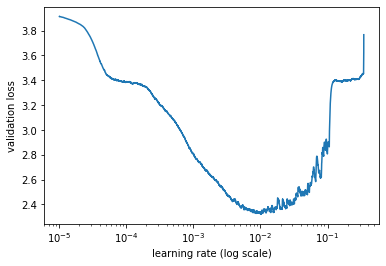

In [11]:
m.lr_find()
m.sched.plot()

Fit the model for a specified number of epochs:

In [12]:
LR = 1e-3
m.fit(LR, 200, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                       
    0      2.117737   2.152133   0.34648   
    1      2.048123   2.028033   0.374526                       
    2      2.018874   2.005237   0.379534                       
    3      2.000444   2.003024   0.381075                       
    4      1.982402   2.006863   0.379584                       
    5      1.968877   1.958874   0.390146                       
    6      1.970172   1.946487   0.391562                       
    7      1.949199   1.935375   0.396452                       
    8      1.949004   1.928752   0.398033                       
    9      1.950622   1.913924   0.401026                       
    10     1.934265   1.918122   0.400099                       
    11     1.934632   1.917151   0.399896                       
    12     1.920567   1.936577   0.397982                       
    13     1.925818   1.941644   0.395689                       
    14     1.93092    1.930465   0.397425     

   125     1.884884   1.880651   0.40995                        
   126     1.876901   1.870684   0.411431                       
   127     1.884332   1.876803   0.411085                       
   128     1.874243   1.880433   0.410614                       
   129     1.876269   1.889186   0.40811                        
   130     1.877369   1.887386   0.408224                       
   131     1.882632   1.864274   0.41291                        
   132     1.885277   1.876055   0.411525                       
   133     1.876771   1.893178   0.407825                       
   134     1.877735   1.866479   0.413244                       
   135     1.87916    1.880612   0.409586                       
   136     1.878015   1.884054   0.409943                       
   137     1.878218   1.881083   0.409041                       
   138     1.879352   1.885184   0.408856                       
   139     1.88823    1.86717    0.412381                       
   140     1.878531   1.8

[array([1.87789]), 0.41066789145933036]

Save the model and Export parameters:

In [13]:
save_model()
export_parameters()

Validation accuracy:  41.066789145933036


Repeat for other Quantization Parameters:

In [14]:
for QP in [27, 32, 37]:
    if 'df' in globals(): del df, y, mapper
    df, y, mapper, emb_szs, val_idx = read_proc()
    export_mapper()
    md = ColumnarModelData.from_data_frame(INP, val_idx, df, y, cat_flds=cat_vars, 
                                           bs=1024, is_multi=False, is_reg=False)
    m = md.get_learner(emb_szs, len(df.columns) - len(cat_vars),
                       0.001, 49, Layers, Dropouts, use_bn=BN_use)
    m.fit(LR, 200, metrics=[accuracy])
    save_model()
    export_parameters()

epoch      trn_loss   val_loss   accuracy                       
    0      2.251285   2.230246   0.336212  
    1      2.185188   2.177998   0.346334                       
    2      2.167491   2.161156   0.350222                       
    3      2.162263   2.142226   0.354434                       
    4      2.149573   2.138094   0.357433                       
    5      2.142468   2.128669   0.357327                       
    6      2.140623   2.125181   0.359065                       
    7      2.134553   2.117276   0.360753                       
    8      2.134821   2.119755   0.359928                       
    9      2.138445   2.1268     0.35925                        
    10     2.123118   2.129384   0.358773                       
    11     2.122763   2.137295   0.357884                       
    12     2.119404   2.105574   0.362864                       
    13     2.128693   2.106975   0.362118                       
    14     2.126564   2.111793   0.360813     

   125     2.092742   2.086062   0.367444                       
   126     2.102051   2.088527   0.367074                       
   127     2.091475   2.085293   0.367427                       
   128     2.093452   2.083246   0.367535                       
   129     2.090811   2.083342   0.367589                       
   130     2.085967   2.083727   0.367412                       
   131     2.097909   2.078935   0.368024                       
   132     2.095851   2.081774   0.367861                       
   133     2.10232    2.086641   0.367372                       
   134     2.097843   2.082095   0.367606                       
   135     2.095465   2.087148   0.366689                       
   136     2.094155   2.096195   0.365688                       
   137     2.090105   2.085544   0.367508                       
   138     2.09818    2.078413   0.368213                       
   139     2.09794    2.084604   0.367164                       
   140     2.084678   2.0

epoch      trn_loss   val_loss   accuracy                       
    0      2.570693   2.562807   0.276942  
    1      2.525522   2.512819   0.285962                       
    2      2.493059   2.482409   0.290363                       
    3      2.491524   2.486799   0.290317                       
    4      2.481328   2.466924   0.292876                       
    5      2.488222   2.486801   0.290872                       
    6      2.473547   2.464014   0.293333                       
    7      2.470779   2.470105   0.293132                       
    8      2.473451   2.460844   0.294632                       
    9      2.464983   2.462757   0.294254                       
    10     2.470553   2.454601   0.295481                       
    11     2.46747    2.454945   0.295405                       
    12     2.46762    2.457988   0.295608                       
    13     2.46015    2.457647   0.295645                       
    14     2.465701   2.456487   0.295651     

   125     2.435239   2.434565   0.298108                       
   126     2.45031    2.437684   0.297829                       
   127     2.438909   2.428932   0.298805                       
   128     2.430963   2.43187    0.299002                       
   129     2.429436   2.427741   0.299032                       
   130     2.437585   2.433655   0.298491                       
   131     2.431628   2.429661   0.299164                       
   132     2.433672   2.432001   0.298909                       
   133     2.441541   2.427646   0.299186                       
   134     2.433734   2.430974   0.29907                        
   135     2.439417   2.429668   0.298884                       
   136     2.435925   2.432282   0.298814                       
   137     2.436406   2.431784   0.298271                       
   138     2.437583   2.429596   0.298754                       
   139     2.449282   2.426179   0.299469                       
   140     2.433646   2.4

epoch      trn_loss   val_loss   accuracy                       
    0      2.921371   2.90938    0.21605   
    1      2.89987    2.88796    0.219401                       
    2      2.888316   2.874784   0.220918                       
    3      2.879358   2.871067   0.221197                       
    4      2.867778   2.863665   0.221997                       
    5      2.86415    2.861782   0.222187                       
    6      2.864426   2.863383   0.222658                       
    7      2.86471    2.851541   0.222756                       
    8      2.860923   2.848922   0.223135                       
    9      2.851355   2.851696   0.223183                       
    10     2.849987   2.84718    0.22356                        
    11     2.839358   2.837114   0.223712                       
    12     2.846703   2.854068   0.223194                       
    13     2.852611   2.854936   0.223352                       
    14     2.843646   2.843774   0.223678     

   125     2.806025   2.800443   0.22647                        
   126     2.81129    2.819079   0.226275                       
   127     2.813928   2.837695   0.226261                       
   128     2.809255   2.800726   0.226199                       
   129     2.808087   2.814727   0.226441                       
   130     2.809284   2.799692   0.226157                       
   131     2.81574    2.810567   0.226219                       
   132     2.817174   2.812699   0.226015                       
   133     2.813151   2.799576   0.226267                       
   134     2.815861   2.806706   0.22579                        
   135     2.824954   2.809991   0.226284                       
   136     2.813512   2.812057   0.226329                       
   137     2.815652   2.802042   0.226272                       
   138     2.817436   2.800607   0.226354                       
   139     2.818641   2.814589   0.225965                       
   140     2.809617   2.8